## Importing Libraries

In [151]:
from pprint import pprint
import pandas as pd
import boto3
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")

### Reading the data

In [152]:
df = pd.read_json(r"E:\customer_churn_prediction\data\processed\df_cleaned_events.json", lines= True)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             278154 non-null  int64  
 1   userId         278154 non-null  int64  
 2   sessionId      278154 non-null  int64  
 3   page           278154 non-null  object 
 4   auth           278154 non-null  object 
 5   method         278154 non-null  object 
 6   status         278154 non-null  int64  
 7   level          278154 non-null  object 
 8   itemInSession  278154 non-null  int64  
 9   location       278154 non-null  object 
 10  userAgent      278154 non-null  object 
 11  lastName       278154 non-null  object 
 12  firstName      278154 non-null  object 
 13  registration   278154 non-null  int64  
 14  gender         278154 non-null  object 
 15  artist         228108 non-null  object 
 16  song           228108 non-null  object 
 17  length         228108 non-nul

Converting ts and registration to datetime

In [154]:
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

In [155]:
# Create time-based features
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.dayofweek
df['month'] = df['ts'].dt.month
df['tenure_days'] = (df['ts'] - df['registration']).dt.days

In [156]:
df = df.sort_values(["userId", "ts"])
df["next_action"] = df.groupby("userId")["page"].shift(-1)
events_post_cancellation = df[
    (df["page"] == "Cancellation Confirmation") & (df["next_action"].notna())
]
print("Events after cancellation:", len(events_post_cancellation))


Events after cancellation: 0


In [157]:
# Create churn DataFrame
user_churn = (
    df.groupby("userId")["page"]
      .apply(lambda x: x.eq("Cancellation Confirmation").any())
      .astype(int)
      .reset_index(name="churn")
)

# Merge churn labels onto main df
df = df.merge(user_churn, on="userId", how="left")
print(f"Churn rate: {df['churn'].mean():.2%}")
print(f"Total churned users: {df['churn'].sum()}")

Churn rate: 16.13%
Total churned users: 44864


# Exploratory Data Analysis (EDA)

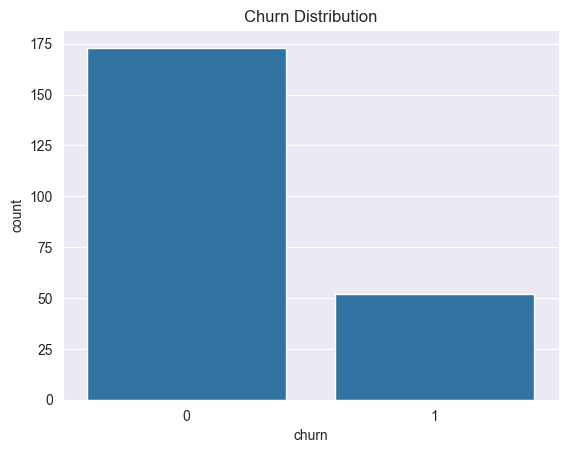

In [158]:
sns.countplot(x="churn", data=user_churn)
plt.title("Churn Distribution")
plt.show()

In [163]:
user_features = df.groupby("userId").agg({
    "gender": "first",
    "location": "first",
    "level": lambda x: x.iloc[-1],   # last known subscription level
    "registration": "first"
}).reset_index()

user_data = user_features.merge(user_churn, on="userId")

<Axes: xlabel='gender', ylabel='count'>

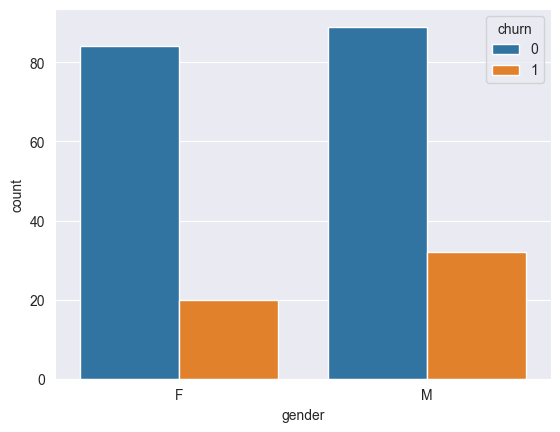

In [164]:
sns.countplot(x="gender", hue="churn", data=user_data)


In [159]:
def plot_top_n_values(df, column_name, n, orient='vertical', fig_size=(6, 4), dropna=False):
    # Drop or fill NaNs
    if dropna:
        values_counts = (
            df[column_name]
            .dropna()
            .value_counts()
            .head(n)
        )
    else:
        values_counts = (
            df[column_name]
            .fillna('Null')
            .value_counts()
            .head(n)
        )
    
    values = values_counts.index.tolist()
    counts = values_counts.values.tolist()
    
    plt.figure(figsize=fig_size)
    
    if orient == 'horizontal':
        plt.barh(values, counts, color='skyblue')
        plt.xlabel('Frequency')
        plt.ylabel('Values')
        plt.title(f'Top {n} values in column {column_name}')
    else:
        plt.bar(values, counts, color='skyblue')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Top {n} values in column {column_name}')
        plt.xticks(rotation=45)
    
    plt.show()


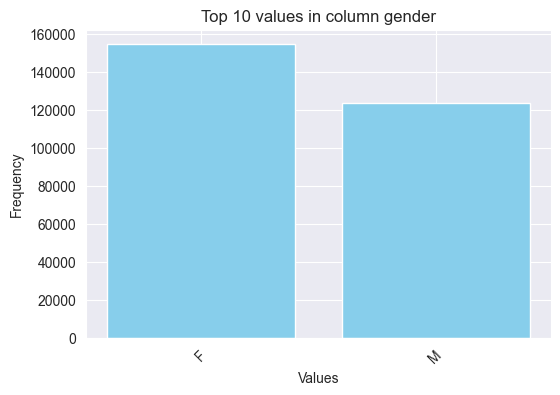

In [160]:
plot_top_n_values(df, 'gender', 10)

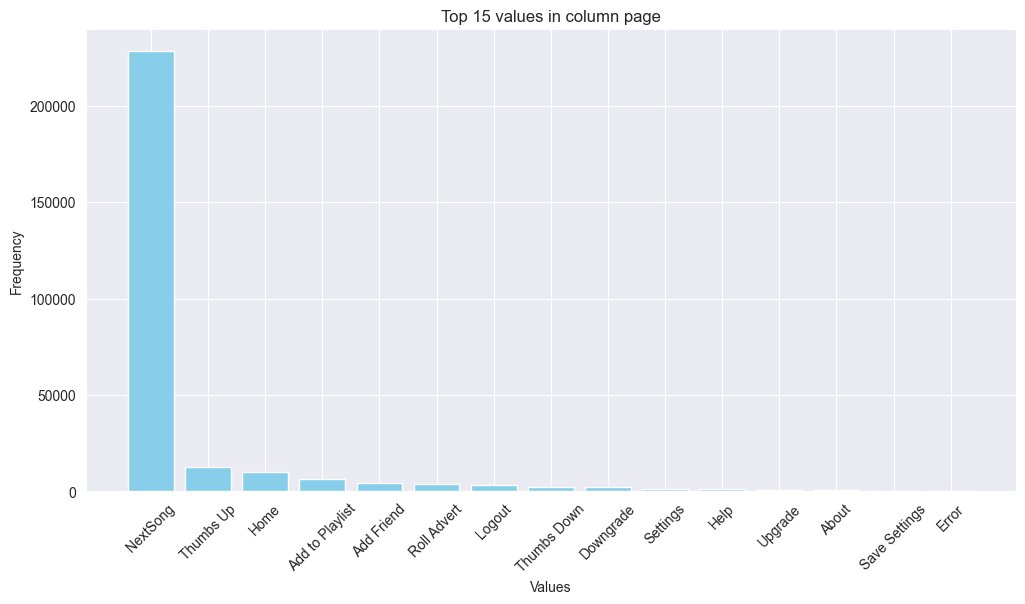

In [161]:
plot_top_n_values(df, 'page', 15, fig_size=(12, 6))

c:\Users\Future\miniconda3\envs\mlops\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


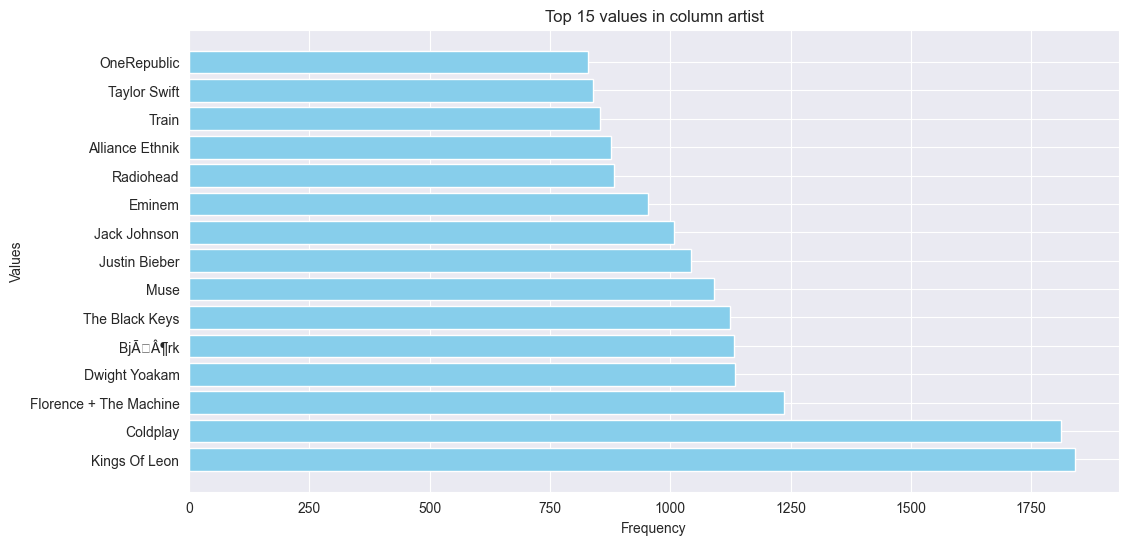

In [162]:
plot_top_n_values(df, 'artist', 15, orient='horizontal', fig_size=(12,6), dropna=True)
